In [1]:
import pickle
import pandas as pd
from models import *
import sys
import torch
import matplotlib.pyplot as plt
import numpy as np

from utils import make_predictions
from load_model import create_and_load_model
from preprocessing_utils import *

sys.path.append('CONFIG_files/')

In [2]:
import CONFIG_COMBINED_BGMM_09_NOV_2023_EXP_2 as C

In [3]:
network = MLP(in_channels=len(C.predictors),
                  hidden_channels= [50,50],
                  likelihood_fn='bgmm',
                  dropout_rate= 0)

In [4]:
PATH = r'/users/marron31/marron31-hpc/_experiments/COMBINED_BGMM_09_NOV_2023_EXP_2_run-lr-0-001-batch-size-32-likelihood-fn-bgmm-dropout-rate-0-random-noise-0-k-0-model-arch-mlp-50-50/model_best.pth.tar'
network.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [5]:
df = pd.read_csv('../../data/norris/maps_for_predictions/2010-01-01.csv')

In [6]:
data = DataPreprocessing(train_path=C.TRAIN_PATH, start=C.start, end=C.end, 
                add_yesterday = False, 
                basin_filter = None, 
                split_bias_corrected_only = False, 
                filter_incomplete_years = False, 
                include_non_bc_stations = True, 
                split_by = C.split_by)

/users/marron31/repos/upper-indus-prec-bc/preprocessing_utils.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[series][df[series] < 0] = 0


In [7]:
data.split_stations(sort_by_elev = False)
data.input_data(C.predictors, C.predictand, sort_by_quantile=C.sort_by_quantile)

In [8]:
df['cape_norris'].fillna(0,inplace=True)

In [9]:
df.year = df.year.transform(lambda x: np.random.normal(loc=x, scale=0.2))

In [10]:
df = df[['doy_sin',
 'doy_cos',
 'Z',
 'X',
 'Y',
 'year',
 'CWV_norris',
 'RH2_norris',
 'RH500_norris',
 'T2_norris',
 'T2max_norris',
 'T2min_norris',
 'Td2_norris',
 'precip_norris',
 'rain_norris',
 'u500_norris',
 'v500_norris',
 'u10_norris',
 'v10_norris',
 'cape_norris',
 'u250_norris',
 'v250_norris',
 'w250_norris',
 'w500_norris',
 'hgt_norris',
 'lu_index_norris']]

In [11]:
mu = data.x_mean
std = data.x_std

x = (df.values-mu)/std

In [12]:
x = torch.tensor(x,dtype=torch.float32)

In [13]:
with torch.no_grad():
    y = network(x)

In [14]:
x.isnan().sum()

tensor(4259)

In [15]:
df['pi'] = y[:,0]
df['alpha'] = y[:,1]
df['beta'] = y[:,2]

In [16]:
from utils import cdf_apply, sample_apply

In [17]:
df.dropna(inplace=True)

In [18]:
df['prob_0_1'] = df.apply(cdf_apply, axis=1, likelihood_fn=network.likelihood, obs=0.1)
df['prob_10'] = df.apply(cdf_apply, axis=1, likelihood_fn=network.likelihood, obs=10)
df['prob_50'] = df.apply(cdf_apply, axis=1, likelihood_fn=network.likelihood, obs=50)

In [19]:
df['uniform'] = df['X'].transform(lambda x: np.random.random())
df['sample_01'] = df.apply(sample_apply, axis=1, likelihood_fn = network.likelihood)
df['occurrence_01'] = df['sample_01'].transform(lambda x: x>0)

In [20]:
wrf_fields =  ['CWV_norris', 'RH2_norris',
               'RH500_norris', 'T2_norris', 'T2max_norris', 'T2min_norris',
               'Td2_norris', 'precip_norris', 'rain_norris', 'u500_norris',
               'v500_norris', 'u10_norris', 'v10_norris', 'cape_norris', 'u250_norris',
               'v250_norris', 'w250_norris', 'w500_norris', 'hgt_norris',
               'lu_index_norris']

prob_fields = ['prob_0_1','prob_10','prob_50','occurrence_01']

full_fields = wrf_fields + prob_fields

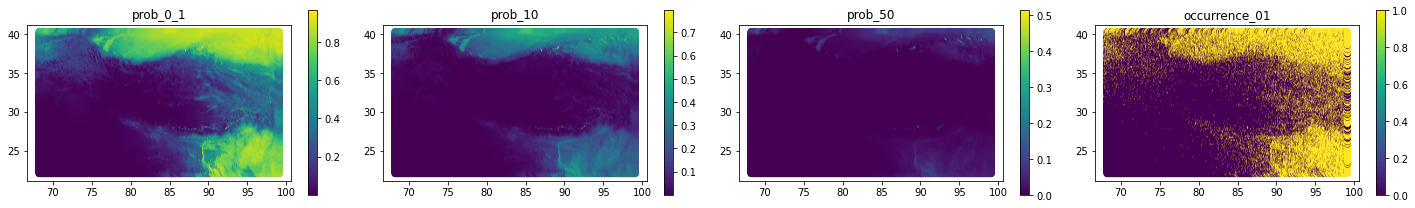

In [22]:
x = df.X
y = df.Y

fig, axes = plt.subplots(nrows=1,ncols=4, figsize=(20,3))

for ax, f in zip(axes.flatten(), prob_fields):
    v = df[f]
    if 'prob' not in f:
        scatter = ax.scatter(x,y,c=v)
    else:
        scatter = ax.scatter(x,y,c=1-v)
        
    ax.set_aspect('equal')
        
    fig.colorbar(scatter, ax=ax)
    ax.set_title(f)
#     ax.axis('off')

plt.tight_layout()
plt.savefig('predictions-panels.png')
plt.show()

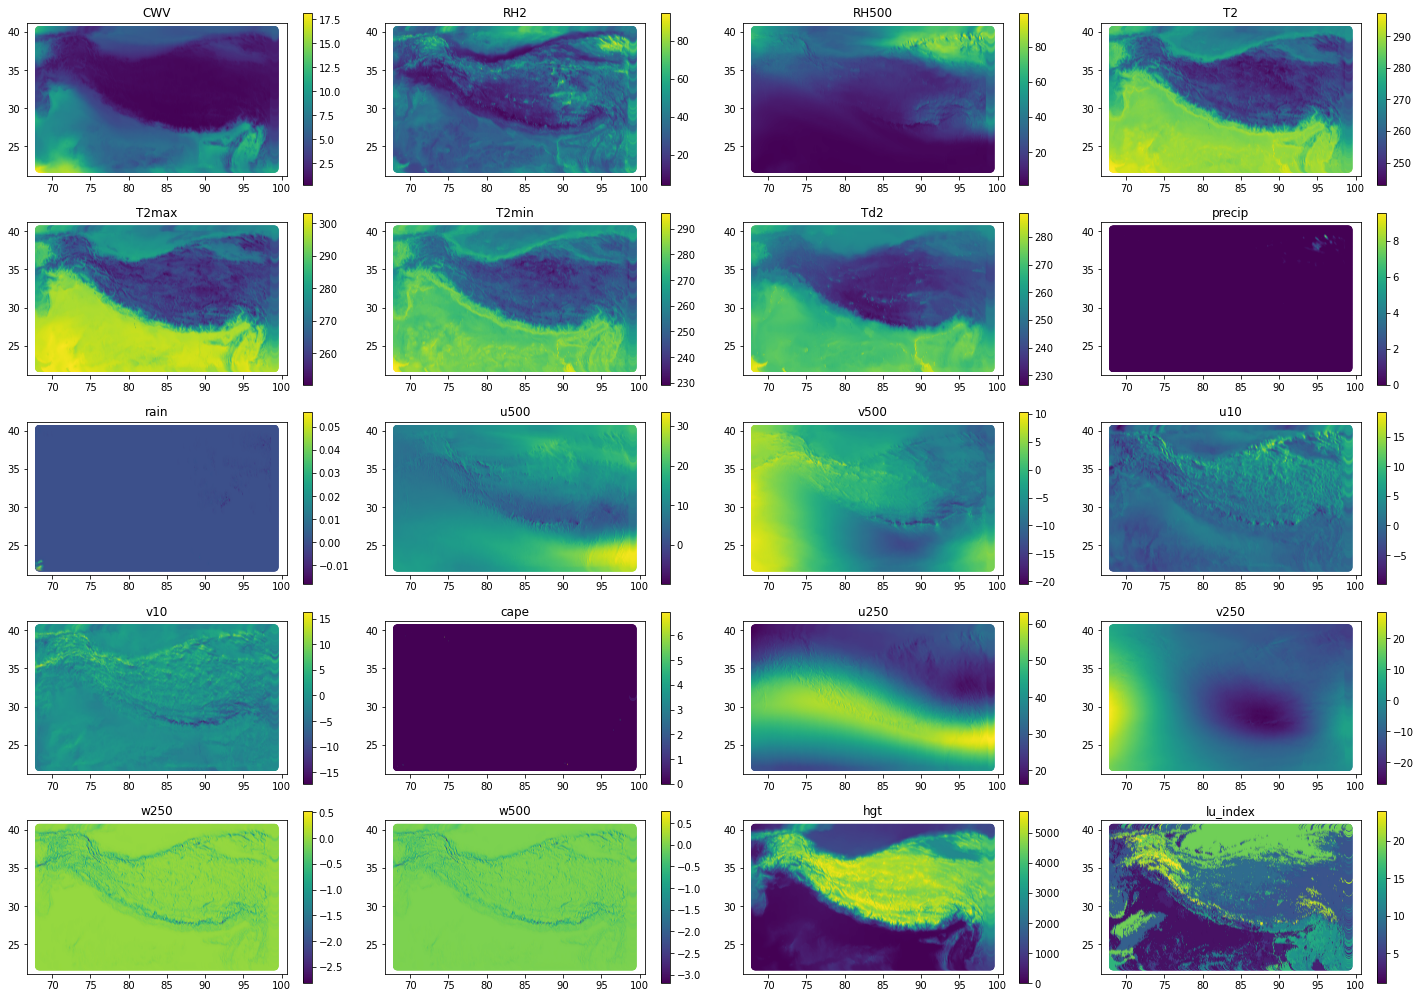

In [21]:
x = df.X
y = df.Y

nrows = 5
ncols = 4

fig, axes = plt.subplots(nrows=5,ncols=4,figsize=(20,20*0.7))

for ax, f in zip(axes.flatten(), wrf_fields):
    v = df[f]
    if 'prob' in f:
        scatter = ax.scatter(x,y,c=1-v)
    else:
        scatter = ax.scatter(x,y,c=v)
                             
    ax.set_aspect('equal')

    fig.colorbar(scatter, ax=ax)
    ax.set_title(f.split('_norris')[0])
#     ax.axis('off')

plt.tight_layout()
plt.show()

In [64]:
st = data.st.groupby('Station').first()[['X','Y','Region']].reset_index()

In [153]:
import geopandas as gpd

In [ ]:
gpd.

In [152]:
st.to_csv('station_coords.csv',index=False)

In [119]:
import contextily as cx

In [22]:
# fig = plt.figure()
# cx.add_basemap(fig.gca(), source=cx.providers.OpenStreetMap.BlackAndWhite)
# plt.show()

/data/hpcdata/users/marron31/conda-envs/bcdp/lib/python3.9/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 23 is not valid for the current tile provider (valid zooms: 0 - 17).
  warnings.warn(msg)


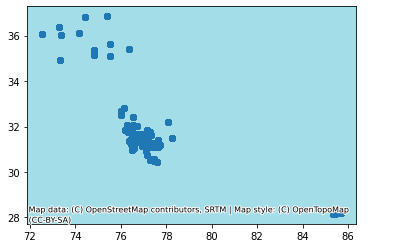

In [147]:
fig = plt.figure()
fig.gca().scatter(data.st.X,data.st.Y)
cx.add_basemap(fig.gca(), source=cx.providers.OpenTopoMap)

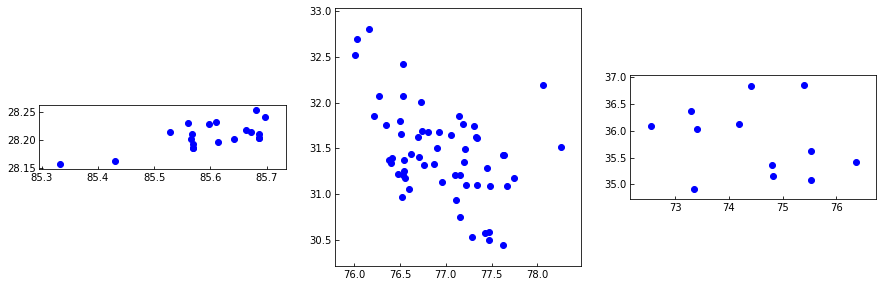

In [150]:
import matplotlib.cm as cm
# import matplotlib.markers as markers

# marker = markers.MarkerStyle(marker='s')

x = df.X
y = df.Y
v = df.Z

fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
for r, ax in zip(st.Region.unique(), axes.flatten()):
#     scatter = ax.scatter(x,y,c=v,cmap=cm.terrain,marker='s',s=2100)
#     ax.colorbar()
    cx.add_basemap(ax, source=cx.providers.Esri.WorldTopoMap, attribution=False)
    ax.scatter(xs,ys,c='blue',marker='o')
    ax.set_aspect('equal')
    x_range = (frames[r]['X_max']-frames[r]['X_min'])
    y_range = (frames[r]['Y_max']-frames[r]['Y_min'])
    ax.set_xlim([frames[r]['X_min']-x_range*0.1,frames[r]['X_max']+x_range*0.1])
    ax.set_ylim([frames[r]['Y_min']-y_range*0.1,frames[r]['Y_max']+y_range*0.1])
    
    ax.tick_params(direction='in', which='both')
#    ax.set_xticklabels([])
#     ax.set_yticklabels([ax.get_yticks()])


# plt.gca().axis('off')
plt.show()

In [82]:
frames = {}
for r in st.Region.unique():
        
    st_r = st[st.Region==r]
    
    frames[r] = {}
    frames[r]['X_min'] = st_r.X.min()
    frames[r]['X_max'] = st_r.X.max()
    frames[r]['Y_min'] = st_r.Y.min()
    frames[r]['Y_max'] = st_r.Y.max()

    print(r, st_r.X.min(),st_r.X.max(),st_r.Y.min(),st_r.Y.max())

Langtang 85.33218 85.69743 28.15743 28.25296
EastUIB 76.01034851068854 78.25468676532721 30.444464321273433 32.801124062793654
WestUIB 72.54 76.37 34.92 36.85
